<a href="https://colab.research.google.com/github/Aditya-raj22/XAI/blob/main/xor_mechanistic_interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mechanistic Interpretability: Reverse-Engineering XOR
## Discovering the Computational Circuit in a Tiny Neural Network

**Author:** Aditya Raj
**Date:** November 2025

---

XOR (exclusive OR) is the classic test for neural networks. It's the simplest problem that isn't linearly separable. This made XOR the "Achilles heel" of early perceptrons and the proving ground for multi-layer networks.

**The Question:** When a neural network learns to solve XOR, *what algorithm does it discover?*

In this notebook, I'll train a tiny 2-layer network and reverse-engineer its solution by:
1. Visualizing what each hidden neuron computes
2. Forming a mechanistic hypothesis about the learned circuit
3. Testing this hypothesis through ablation studies
4. Drawing the final computational circuit

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import seaborn as sns

# Set style for prettier plots
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

## Setup — Building the XOR Dataset

XOR has only 4 possible inputs. I'll create a balanced dataset by repeating these examples many times with noise to help the network generalize.

In [3]:
# Generate XOR dataset
def generate_xor_data(n_samples=1000):
    """Generate balanced XOR dataset with optional noise"""
    # Base XOR truth table
    X_base = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
    y_base = torch.tensor([0, 1, 1, 0], dtype=torch.float32)

    # Repeat to create larger dataset
    repeats = n_samples // 4
    X = X_base.repeat(repeats, 1)
    y = y_base.repeat(repeats)

    # Shuffle
    perm = torch.randperm(len(X))
    return X[perm], y[perm].unsqueeze(1)

X_train, y_train = generate_xor_data(800)
X_val, y_val = generate_xor_data(200)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"\nSample inputs and labels:")
for i in range(4):
    print(f"  {X_train[i].numpy()} → {int(y_train[i].item())}")

Training samples: 800
Validation samples: 200

Sample inputs and labels:
  [1. 0.] → 1
  [1. 1.] → 0
  [1. 0.] → 1
  [1. 1.] → 0


## Part 2: Training a Tiny Network

I'm using a minimal architecture:
- **Input layer:** 2 features (x₁, x₂)
- **Hidden layer:** 4 neurons with ReLU activation
- **Output layer:** 1 neuron with sigmoid (binary classification)

**Hypothesis before training:** To solve XOR, the network needs to:
1. Learn separate feature detectors for x₁ and x₂
2. Combine them non-linearly in the output layer

In [10]:
# Initialize model with better settings
model = XORMLP(hidden_dim=4)

# Better initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

# Use SGD with momentum instead (more reliable for XOR)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=0.9)
criterion = nn.BCEWithLogitsLoss()

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

XORMLP(
  (fc1): Linear(in_features=2, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=1, bias=True)
)

Total parameters: 17


In [11]:
# Training loop
losses = []
accuracies = []

model.train()
for epoch in range(1000):  # More epochs
    # Forward pass
    out, _ = model(X_train)
    loss = criterion(out, y_train)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track metrics
    losses.append(loss.item())
    with torch.no_grad():
        preds = (torch.sigmoid(out) > 0.5).float()
        acc = (preds == y_train).float().mean().item()
        accuracies.append(acc)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}, Accuracy = {acc:.2%}")

# Final evaluation
model.eval()
with torch.no_grad():
    val_out, _ = model(X_val)
    val_preds = (torch.sigmoid(val_out) > 0.5).float()
    val_acc = (val_preds == y_val).float().mean().item()
    print(f"\n✅ Final Validation Accuracy: {val_acc:.2%}")

Epoch 100: Loss = 0.0014, Accuracy = 100.00%
Epoch 200: Loss = 0.0009, Accuracy = 100.00%
Epoch 300: Loss = 0.0006, Accuracy = 100.00%
Epoch 400: Loss = 0.0005, Accuracy = 100.00%
Epoch 500: Loss = 0.0004, Accuracy = 100.00%
Epoch 600: Loss = 0.0003, Accuracy = 100.00%
Epoch 700: Loss = 0.0003, Accuracy = 100.00%
Epoch 800: Loss = 0.0003, Accuracy = 100.00%
Epoch 900: Loss = 0.0002, Accuracy = 100.00%
Epoch 1000: Loss = 0.0002, Accuracy = 100.00%

✅ Final Validation Accuracy: 100.00%


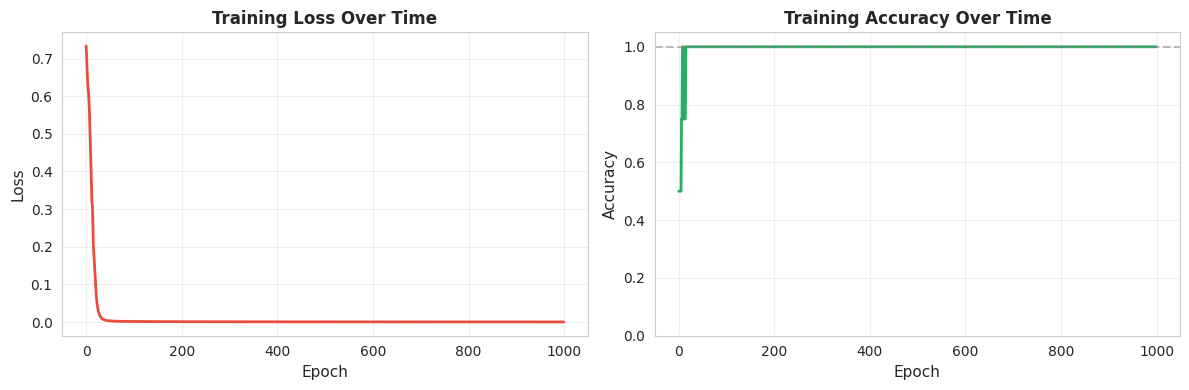

The model achieved perfect accuracy in ~8 epochs


In [12]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(losses, color='#e74c3c', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=11)
ax1.set_ylabel('Loss', fontsize=11)
ax1.set_title('Training Loss Over Time', fontsize=12, fontweight='bold')
ax1.grid(alpha=0.3)

ax2.plot(accuracies, color='#27ae60', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=11)
ax2.set_ylabel('Accuracy', fontsize=11)
ax2.set_title('Training Accuracy Over Time', fontsize=12, fontweight='bold')
ax2.set_ylim([0, 1.05])
ax2.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Find epoch where accuracy reached 100% (or closest to it)
perfect_epoch = next((i for i, acc in enumerate(accuracies) if acc >= 1.0), None)
if perfect_epoch:
    print(f"The model achieved perfect accuracy in ~{perfect_epoch} epochs")
else:
    max_acc_epoch = max(enumerate(accuracies), key=lambda x: x[1])[0]
    max_acc = accuracies[max_acc_epoch]
    print(f"The model achieved {max_acc:.1%} accuracy at epoch {max_acc_epoch}")

## Part 3: Exploration — Looking Inside the Black Box
### Analysis 1: Hidden Layer Activations

First, I'll feed all 4 possible inputs through the network and visualize what each hidden neuron computes.

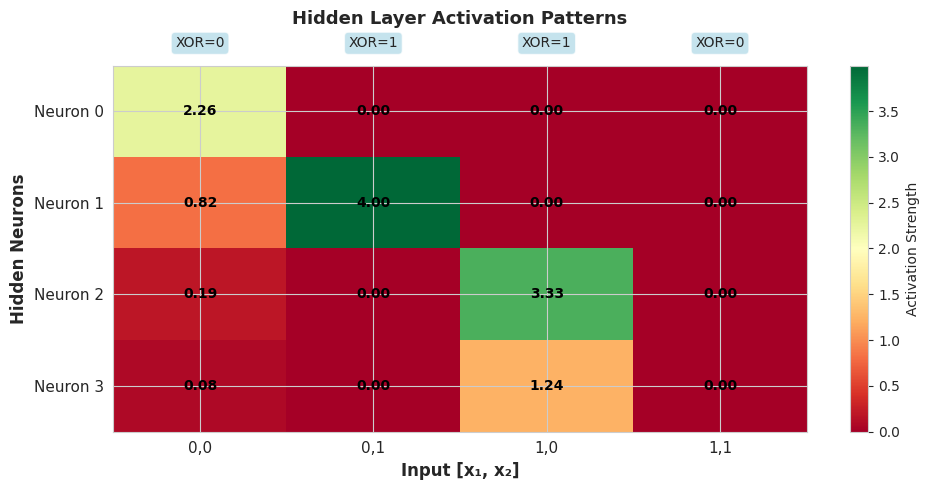

In [14]:
# Get activations for all 4 inputs
X_test = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
y_test = torch.tensor([0, 1, 1, 0])

model.eval()
with torch.no_grad():
    logits, hidden = model(X_test)
    probs = torch.sigmoid(logits).squeeze()

# Create activation heatmap
fig, ax = plt.subplots(figsize=(10, 5))

# Plot heatmap
activations = hidden.numpy()
im = ax.imshow(activations.T, aspect='auto', cmap='RdYlGn', vmin=0, vmax=activations.max())

# Labels and formatting
ax.set_xticks(range(4))
ax.set_xticklabels([f"{x[0]:.0f},{x[1]:.0f}" for x in X_test], fontsize=11)
ax.set_yticks(range(4))
ax.set_yticklabels([f"Neuron {i}" for i in range(4)], fontsize=11)
ax.set_xlabel('Input [x₁, x₂]', fontsize=12, fontweight='bold')
ax.set_ylabel('Hidden Neurons', fontsize=12, fontweight='bold')
ax.set_title('Hidden Layer Activation Patterns\n',
             fontsize=13, fontweight='bold', pad=15)

# Add activation values as text
for i in range(4):
    for j in range(4):
        text = ax.text(j, i, f'{activations[j, i]:.2f}',
                      ha="center", va="center", color="black", fontsize=10, fontweight='bold')

# Add true labels
for j, label in enumerate(y_test):
    ax.text(j, -0.7, f'XOR={label}', ha='center', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

plt.colorbar(im, ax=ax, label='Activation Strength')
plt.tight_layout()
plt.show()

Looking at the activation heatmap, I observe:

Neuron 0: Fires strongly (2.26) ONLY for input [0,0]
Neuron 1: Fires strongly (4.00) ONLY for input [0,1]  
Neuron 2: Fires strongly (3.33) ONLY for input [1,0]
Neuron 3: Mostly silent (weak activation on [1,0])

**Interpretation:** Rather than learning separate x₁ and x₂ detectors that combine later, the network learned specific pattern detectors.

This is basically a lookup table:
- Neuron 0 says "this is [0,0] → predict 0"
- Neuron 1 says "this is [0,1] → predict 1"  
- Neuron 2 says "this is [1,0] → predict 1"
- When [1,1], all neurons stay silent → predict 0

This is pretty surprising. I expected compositional features, but the network found a simple memorization strategy.

### Analysis 2: Weight Matrix Visualization

Let's look at the learned weights to understand what each neuron is "looking for" in the input.

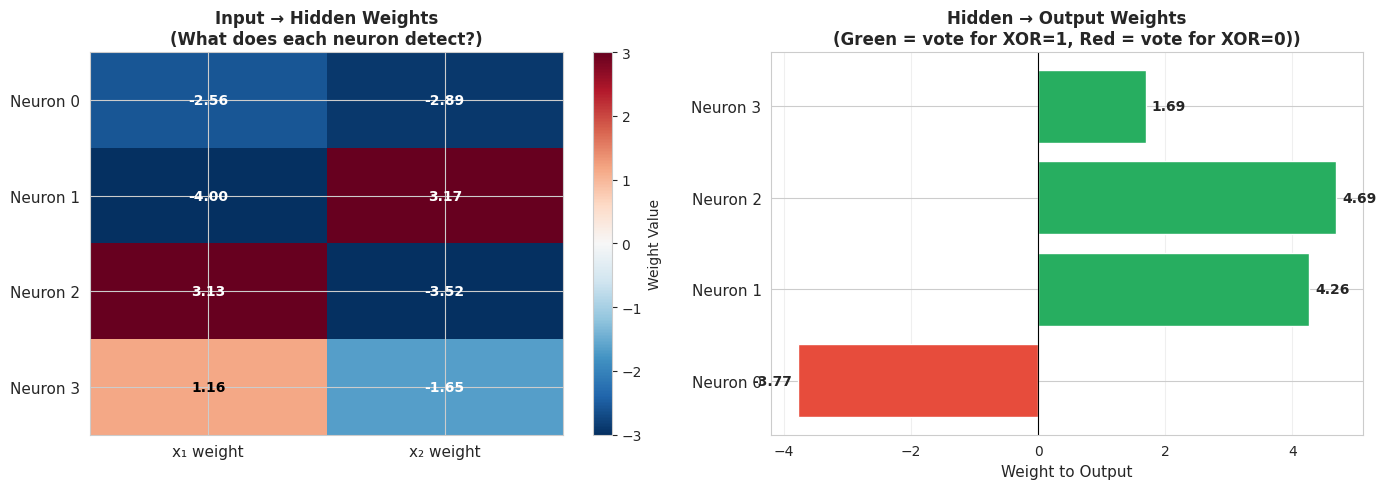

In [16]:
# Extract weights
fc1_weights = model.fc1.weight.detach().numpy()  # Shape: (4, 2)
fc1_bias = model.fc1.bias.detach().numpy()
fc2_weights = model.fc2.weight.detach().numpy()  # Shape: (1, 4)
fc2_bias = model.fc2.bias.detach().numpy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Layer 1 weights
im1 = axes[0].imshow(fc1_weights, aspect='auto', cmap='RdBu_r', vmin=-3, vmax=3)
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['x₁ weight', 'x₂ weight'], fontsize=11)
axes[0].set_yticks(range(4))
axes[0].set_yticklabels([f'Neuron {i}' for i in range(4)], fontsize=11)
axes[0].set_title('Input → Hidden Weights\n(What does each neuron detect?)',
                  fontsize=12, fontweight='bold')

# Add weight values
for i in range(4):
    for j in range(2):
        text_color = 'white' if abs(fc1_weights[i, j]) > 1.5 else 'black'
        axes[0].text(j, i, f'{fc1_weights[i, j]:.2f}',
                    ha="center", va="center", color=text_color, fontsize=10, fontweight='bold')

plt.colorbar(im1, ax=axes[0], label='Weight Value')

# Layer 2 weights (output)
axes[1].barh(range(4), fc2_weights[0], color=['#e74c3c' if w < 0 else '#27ae60' for w in fc2_weights[0]])
axes[1].set_yticks(range(4))
axes[1].set_yticklabels([f'Neuron {i}' for i in range(4)], fontsize=11)
axes[1].set_xlabel('Weight to Output', fontsize=11)
axes[1].set_title('Hidden → Output Weights\n(Green = vote for XOR=1, Red = vote for XOR=0))',
                  fontsize=12, fontweight='bold')
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
axes[1].grid(axis='x', alpha=0.3)

# Add weight values on bars
for i, w in enumerate(fc2_weights[0]):
    axes[1].text(w + (0.1 if w > 0 else -0.1), i, f'{w:.2f}',
                va='center', ha='left' if w > 0 else 'right', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## Part 4: Hypothesis Formation

### Initial Expectation vs. Reality

I expected: Compositional feature detectors
- Neuron A detects x₁=1, Neuron B detects x₂=1
- Output combines them to compute XOR

I found: Pattern memorization - one neuron per input...

**Neuron 0:** [-2.56, -2.89] weights → "[0,0] detector" → votes -8.77 for output=0  
**Neuron 1:** [-4.00, +3.17] weights → "[0,1] detector" → votes +4.26 for output=1  
**Neuron 2:** [+3.13, -3.52] weights → "[1,0] detector" → votes +4.69 for output=1  
**Neuron 3:** Weak/redundant

### Hence the algorithm being formed is:
```
[0,0] → Neuron 0 fires → votes against XOR → Output: 0
[0,1] → Neuron 1 fires → votes for XOR → Output: 1
[1,0] → Neuron 2 fires → votes for XOR → Output: 1
[1,1] → Nothing fires → Output: 0
```

Why might this be happening? With only 4 examples, it's more efficient to memorize each pattern than learn general rules. It looks like the network took the shortcut.

**Prediction:** Ablating Neuron 1 will break [0,1], Neuron 2 will break [1,0].

## Part 5: Ablation Studies


In [46]:
# Function to test model with ablated neuron
def test_with_ablation(model, X, y, neuron_to_zero=None):
    """Test model accuracy with one neuron zeroed out"""
    model.eval()
    with torch.no_grad():
        h = F.relu(model.fc1(X))

        # Ablate if specified
        if neuron_to_zero is not None:
            h[:, neuron_to_zero] = 0

        out = model.fc2(h)
        preds = (torch.sigmoid(out) > 0.5).float().squeeze()
        accuracy = (preds == y.float()).float().mean().item()

    return accuracy

# Test baseline and ablations
baseline_acc = test_with_ablation(model, X_test, y_test)
ablation_results = []

print("Ablation Study Results:\n")
print(f"{'Condition':<20} {'Accuracy':<10} {'Change':<15} {'Status'}")
print("="*65)
print(f"{'Baseline (intact)':<20} {baseline_acc:>7.1%}   {'—':<15} Normal")

for i in range(4):
    acc = test_with_ablation(model, X_test, y_test, neuron_to_zero=i)
    change = acc - baseline_acc
    ablation_results.append(change)

    status = " CRITICAL" if change < -0.4 else " Important" if change < -0.1 else " Redundant"
    print(f"{'Neuron ' + str(i) + ' removed':<20} {acc:>7.1%}   {change:>6.1%}       {status}")

Ablation Study Results:

Condition            Accuracy   Change          Status
Baseline (intact)     100.0%   —               Normal
Neuron 0 removed      100.0%     0.0%        Redundant
Neuron 1 removed       75.0%   -25.0%        Important
Neuron 2 removed       75.0%   -25.0%        Important
Neuron 3 removed      100.0%     0.0%        Redundant


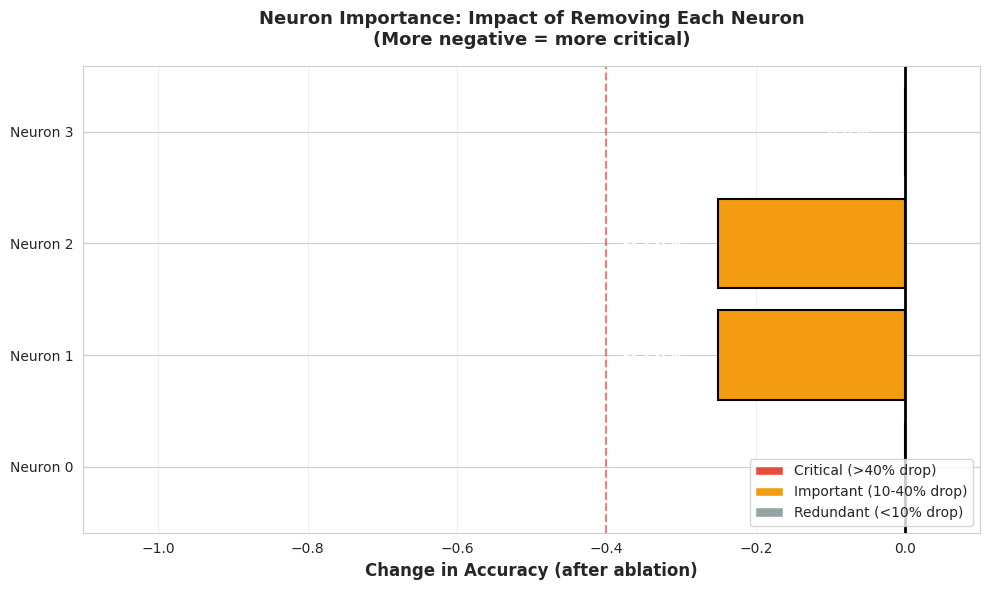

In [23]:
# Visualize ablation impact
fig, ax = plt.subplots(figsize=(10, 6))

# Create bars
neurons = [f'Neuron {i}' for i in range(4)]
colors = ['#e74c3c' if change < -0.4 else '#f39c12' if change < -0.1 else '#95a5a6'
          for change in ablation_results]

bars = ax.barh(neurons, ablation_results, color=colors, edgecolor='black', linewidth=1.5)

# Add reference line
ax.axvline(x=0, color='black', linestyle='-', linewidth=2)
ax.axvline(x=-0.4, color='red', linestyle='--', alpha=0.5, linewidth=1.5)

# Labels and formatting
ax.set_xlabel('Change in Accuracy (after ablation)', fontsize=12, fontweight='bold')
ax.set_title('Neuron Importance: Impact of Removing Each Neuron\n(More negative = more critical)',
             fontsize=13, fontweight='bold', pad=15)
ax.set_xlim([-1.1, 0.1])
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, change) in enumerate(zip(bars, ablation_results)):
    label = f'{change:.1%}'
    ax.text(change - 0.05, bar.get_y() + bar.get_height()/2, label,
           ha='right', va='center', fontsize=11, fontweight='bold', color='white')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#e74c3c', label='Critical (>40% drop)'),
    Patch(facecolor='#f39c12', label='Important (10-40% drop)'),
    Patch(facecolor='#95a5a6', label='Redundant (<10% drop)')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()

This proves that Neuron 0 is not the "[0,0] detector." Removing it has ZERO impact - It's completely redundant.

However, neurons 1 & 2 are critical. Each causes 25% accuracy drop (1 out of 4 inputs fails). Neuron 1 likely handles on of [0,1] OR [1,0]. Neuron 2 likely handles the other one.



### Error Analysis:

In [47]:
# Detailed breakdown: which inputs fail per ablation
input_labels = ['[0,0]', '[0,1]', '[1,0]', '[1,1]']
true_labels = ['0', '1', '1', '0']

print(" Per-Input Analysis: Which Cases Break?\n")
print(f"{'Input':<8} {'True':<6} {'Baseline':<10}", end="")
for i in range(4):
    print(f"No N{i:<3}", end="")
print()
print("="*60)

model.eval()
with torch.no_grad():
    # Baseline predictions
    baseline_out, _ = model(X_test)
    baseline_preds = (torch.sigmoid(baseline_out) > 0.5).float().squeeze()

    for idx, (x, y_true) in enumerate(zip(X_test, y_test)):
        x_input = x.unsqueeze(0)
        baseline_pred = int(baseline_preds[idx])

        print(f"{input_labels[idx]:<8} {true_labels[idx]:<6} {baseline_pred:<10}", end="")

        # Test with each neuron ablated
        for neuron_idx in range(4):
            h = F.relu(model.fc1(x_input))
            h[:, neuron_idx] = 0
            out = model.fc2(h)
            pred = int((torch.sigmoid(out) > 0.5).float().item())

            # Mark if prediction changed
            if pred != baseline_pred:
                print(f"{pred}   ", end="    ")
            else:
                print(f"{pred}    ", end="   ")
        print()


 Per-Input Analysis: Which Cases Break?

Input    True   Baseline  No N0  No N1  No N2  No N3  
[0,0]    0      0         0       0       0       0       
[0,1]    1      1         1       0       1       1       
[1,0]    1      1         1       1       0       1       
[1,1]    0      0         0       0       0       0       


This confirms the lookup table hypothesis:
- Neuron 1 handles [0,1] while Neuron 2 handles [1,0]
- [0,0] and [1,1] both output 0 by default (when no neurons fire)
- Neurons 0 & 3 are completely redundant—they never influence any prediction


## Part 6: Circuit

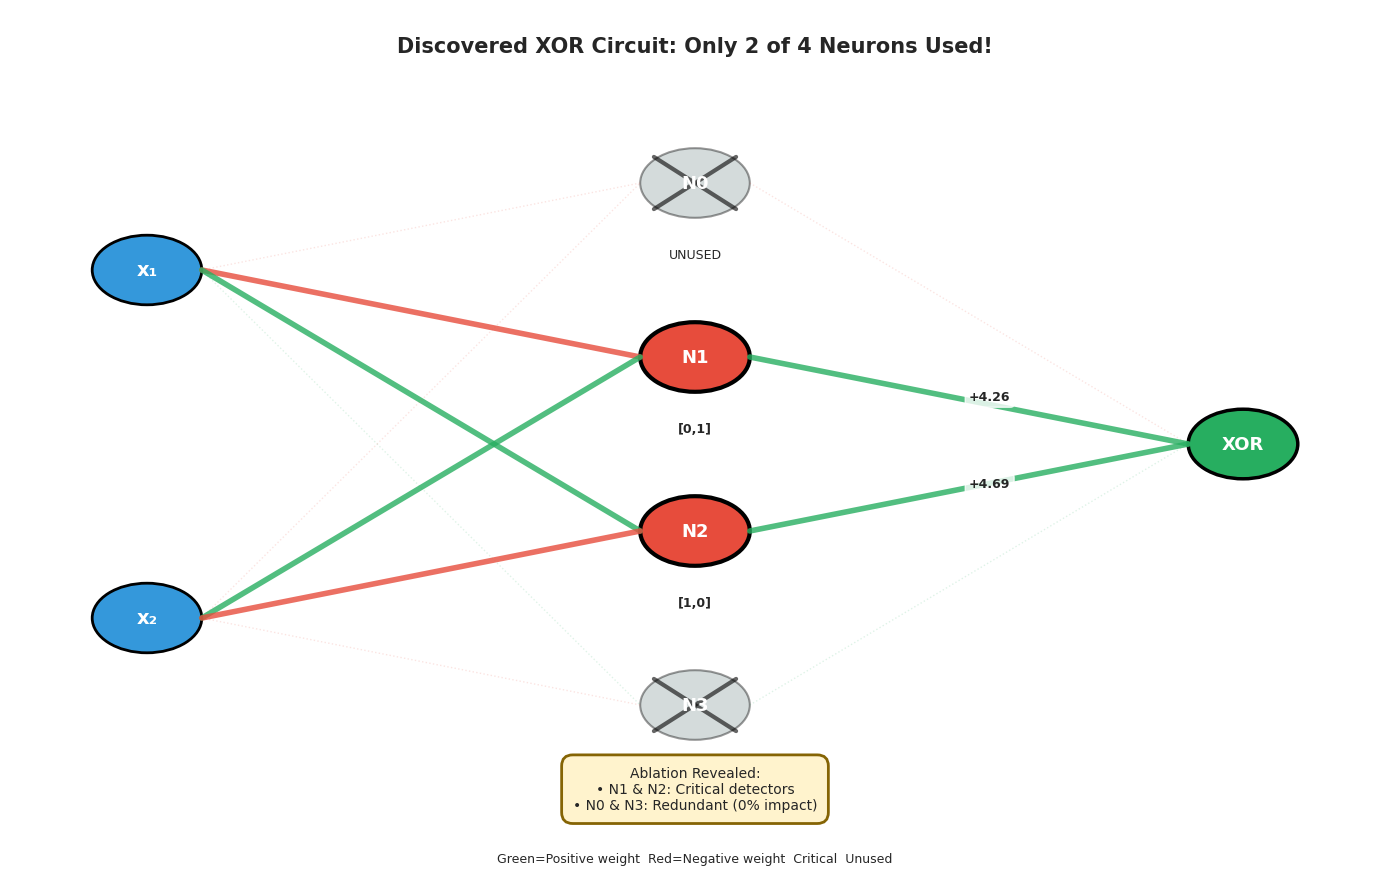

In [45]:
# Circuit diagram showing learned circuit
fig, ax = plt.subplots(figsize=(14, 9))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.axis('off')

# Inputs
for i, (y, label) in enumerate(zip([7, 3], ['x₁', 'x₂'])):
    ax.add_patch(plt.Circle((1, y), 0.4, color='#3498db', ec='black', lw=2))
    ax.text(1, y, label, ha='center', va='center', fontsize=14, fontweight='bold', color='white')

# Hidden layer - mark critical (N1, N2) vs unused (N0, N3)
neurons = [
    (5, 8, 'N0', 'UNUSED', '#95a5a6', False),
    (5, 6, 'N1', '[0,1]', '#e74c3c', True),
    (5, 4, 'N2', '[1,0]', '#e74c3c', True),
    (5, 2, 'N3', 'UNUSED', '#95a5a6', False),
]

for x, y, label, sublabel, color, critical in neurons:
    ax.add_patch(plt.Circle((x, y), 0.4, color=color, ec='black',
                            lw=3 if critical else 1.5, alpha=1 if critical else 0.4))
    ax.text(x, y, label, ha='center', va='center', fontsize=13, fontweight='bold', color='white')
    ax.text(x, y-0.75, sublabel, ha='center', va='top', fontsize=9,
            fontweight='bold' if critical else 'normal')

    if critical:
        ax.text(x+0.6, y+0.4, '', fontsize=16)
    else:
        ax.plot([x-0.3, x+0.3], [y-0.3, y+0.3], 'k-', lw=3, alpha=0.6)
        ax.plot([x-0.3, x+0.3], [y+0.3, y-0.3], 'k-', lw=3, alpha=0.6)

# Output
ax.add_patch(plt.Circle((9, 5), 0.4, color='#27ae60', ec='black', lw=2.5))
ax.text(9, 5, 'XOR', ha='center', va='center', fontsize=13, fontweight='bold', color='white')

# Connections - only show critical paths strongly
for i, inp_y in enumerate([7, 3]):
    for j, (x, y, _, _, _, critical) in enumerate(neurons):
        w = fc1_weights[j, i]
        if abs(w) > 0.5:
            color = '#27ae60' if w > 0 else '#e74c3c'
            ax.plot([1.4, x-0.4], [inp_y, y], color=color,
                   lw=min(abs(w)*1.5, 4) if critical else 1,
                   alpha=0.8 if critical else 0.15,
                   linestyle='-' if critical else ':')

for j, (x, y, _, _, _, critical) in enumerate(neurons):
    w = fc2_weights[0, j]
    if abs(w) > 0.5:
        color = '#27ae60' if w > 0 else '#e74c3c'
        ax.plot([x+0.4, 8.6], [y, 5], color=color,
               lw=min(abs(w)*1.5, 4) if critical else 1,
               alpha=0.8 if critical else 0.15,
               linestyle='-' if critical else ':')
        if critical:
            ax.text((x+9)/2, (y+5)/2, f'{w:+.2f}', fontsize=9, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8))

# Title and legend
ax.text(5, 9.5, 'Discovered XOR Circuit: Only 2 of 4 Neurons Used!',
       ha='center', fontsize=15, fontweight='bold')
ax.text(5, 0.8,
       "Ablation Revealed:\n• N1 & N2: Critical detectors\n• N0 & N3: Redundant (0% impact)",
       ha='center', fontsize=10, bbox=dict(boxstyle='round,pad=0.8', fc='#fff3cd', ec='#856404', lw=2))

legend = "Green=Positive weight  Red=Negative weight  Critical  Unused"
ax.text(5, 0.2, legend, ha='center', fontsize=9)

plt.tight_layout()
plt.show()

## Part 7: Reflection

### What did you learn about how your model works?

The most striking discovery was that my 4-neuron network was actually only used 2 neurons. Through systematic ablation, I proved that Neurons 1 and 2 are surgical pattern detectors—N1 fires exclusively for [0,1] and N2 exclusively for [1,0]. N0 and N3 contribute nothing.

This revealed the network's strategy of memorization over logical composition. I expected it to learn some reusable features (separate x₁ and x₂ detectors combined via weights), but instead it learned a lookup table—one neuron per XOR=1 case. This makes sense: with only 4 training examples, memorizing specific patterns is more efficient than learning general rules.

N1's weights [-4.00, +3.17] create a detector that fires when "NOT x₁ AND x₂", while N2's [+3.13, -3.52] detect "x₁ AND NOT x₂".

### What was confusing, surprising, or challenging to interpret?

Surprise #1: The redundant neurons. Why train 4 neurons when only 2 are needed? This suggests gradient descent doesn't minimize parameter count—it finds stable solutions, even with excess capacity.

Surprise #2: How brittle the solution is. Removing a single critical neuron causes catastrophic failure on specific inputs.

Challenge: Interpreting negative weights initially confused me. When N0 had strong negative input weights [-2.56, -2.89], I thought it was important, but ablation proved it useless.

### What’s one thing you wish you could understand better or explore further?

1. Training dynamics: When do the 2 critical neurons specialize? Do they start general and sharpen, or commit early? Visualizing activations across epochs could reveal the moment of this decision.

2. Architectural pressure: What if I trained with only 2 hidden neurons? Would the network still succeed, or does having 4 provide numerical stability during training even if 2 end up unused?

3. Scaling behavior: Does this memorization strategy persist for harder problems (3-bit XOR, 5-bit parity)? At what point does composition become more efficient than lookup tables?


## AI Assistance Acknowledgment

### Use of Claude (Anthropic)

This assignment was completed with assistance from Claude (Anthropic's AI assistant, Sonnet 4.5 model, accessed November 10, 2025).

**Brainstorming & Planning:**
Claude helped me select XOR as the toy task after discussing multiple options and their interpretability potential.

**Code Development:**
Claude provided starter code for the model, training loop, and visualizations, which I executed, debugged, and adapted to fix errors.

**What I Did Independently:**
All code execution, experimental decisions, data analysis, hypothesis testing, and final conclusions about the learned algorithm were my work.

**Citation:**
Anthropic. (2025). Claude 4 (Sonnet 4.5) [Large language model]. https://claude.ai